<span style="font-size: 30px;">Is there evidence suggesting that the location of a property influences its price to size, number of bathrooms, or number of bedrooms ratio, and can we model the price of homes on these variables?</span>

<span style="font-size: 15px;">ECO225 Project 1 2024 By Samuel Ahn</span>
<span style="font-size: 15px;">1009008967, ahnsamue, sam.ahn@mail.utoronto.ca</span>

<span style="font-size: 30px;">Introduction:</span>

The United States real estate market has consistantly been a high-focus area for economic research. Given the importance of a home, as both a major financial asset and a residential property, being able to model the market has been the goal of both researchers and private institutions for as long as the market has existed CITE. Using data collected by Ahmed Shahriar Sakib from Realtor.com (https://www.realtor.com/), this paper will aim to distinguish preferences for home qualities across America, and use said information to predict the market value of a home given it's characteristics. 

<span style="font-size: 30px;">Data Cleaning/Loading:</span>

In [2]:
#import libraries   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

C:\Users\Sam\AppData\Local\Temp\ipykernel_24584\1834576943.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#read dataset and convert into a dataframe object
realtor= pd.read_csv("realtor-data.csv")
df=realtor.copy()

There are two steps to clean the data, being removing houses that are currently listed as "ready to build" instead of on the market, as the reported information about them is significantly more speculative, and then adding a dummy variable representing if the house has been sold before. The first step will allow for more conclusive results to the study, and will not significantly impact the amount of data available the analyze. The second step will help us create figures and histograms later within the paper. 

In [4]:
#Removing houses not yet on the market
df.drop(df[df["status"] == "ready_to_build"].index, inplace=True)
df.drop(columns="status", inplace=True)

#Adding a dummy variable representing if a house has been sold before
df["sold_before"]=np.where(df.prev_sold_date.isnull(),0,1)

This is what the dataset currently looks like:

In [5]:
#inspect dataset
df.head()

,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,sold_before
0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0,0
1,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0,0
2,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0,0
3,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0,0
4,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0,0


<span style="font-size: 30px;">Summary Statistics Tables:</span>

In [6]:
#printing summary statistics for numerical columns
summary_stats = df.describe().T
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
bed,1182606.0,3.393161,2.053180e+00,1.0,2.00,3.00,4.00,123.0
bath,1206853.0,2.487426,1.873599e+00,1.0,2.00,2.00,3.00,198.0
acre_lot,1043599.0,32.150131,1.249983e+03,0.0,0.12,0.32,1.34,100000.0
zip_code,1398655.0,8359.087318,4.129099e+03,601.0,5655.00,8759.00,11426.00,99999.0
house_size,949022.0,2177.853815,3.495979e+03,4.0,1168.00,1700.00,2500.00,1450112.0
price,1399097.0,818471.244103,2.684814e+06,0.0,235000.00,445000.00,795000.00,875000000.0
sold_before,1399134.0,0.510868,4.998820e-01,0.0,0.00,1.00,1.00,1.0


This summary statistics table displays several interesting and important qualities of the data. Firstly, these data have several extreme outliers. This can be seen in the large disparity between the 75th and max values for the bath, bed, acre_lot, price, and house_size variables. These outliers are significantly larger than all other entried, and thus therefore could potentially impact the conclusions of the study. These outliers are an intesting set of data by their own right, and could potentially represent an opportunity to investigate trends in the high-end and multi-residential real estate market, but given the target of this specific study is a traditional American home-buyer, the dataframe object will be edited to remove siginificant outliers in these variables. 

The metric used to determine an extreme outlier within this dataset will be the interquartile range (IQR). The IQR method is used instead of z-scores due to the skewed distribution of the data, which will be shown later in the paper. An 'extreme outlier' in this paper represents a datapoint with a value for any of the afforementioned 5 variables that surprasses 3 times the IQR from the 25th and 75th percentile values for that variable.

In [7]:
#identifying which variables we would like to remove outliers for
columns_to_remove_outliers = {'bed','bath','acre_lot','price','house_size'}
data_missing = df.copy()
#we establish the IQRs first to avoid the problems associated with the fact that many 

for column in columns_to_remove_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = (df[column] < (Q1 - 3 * IQR)) | (df[column] > (Q3 + 3 * IQR))
    data_missing = data_missing.loc[~outliers_iqr]

#creating a version of the data with no missing values in 
data = data_missing.dropna()
#creating a version sorted by state
data_by_state = data.groupby('state')

#printing summary statistics for new cropped data and data with no missing values
summary_stats_no_missing = data.describe().T
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
bed,1182606.0,3.393161,2.053180e+00,1.0,2.00,3.00,4.00,123.0
bath,1206853.0,2.487426,1.873599e+00,1.0,2.00,2.00,3.00,198.0
acre_lot,1043599.0,32.150131,1.249983e+03,0.0,0.12,0.32,1.34,100000.0
zip_code,1398655.0,8359.087318,4.129099e+03,601.0,5655.00,8759.00,11426.00,99999.0
house_size,949022.0,2177.853815,3.495979e+03,4.0,1168.00,1700.00,2500.00,1450112.0
price,1399097.0,818471.244103,2.684814e+06,0.0,235000.00,445000.00,795000.00,875000000.0
sold_before,1399134.0,0.510868,4.998820e-01,0.0,0.00,1.00,1.00,1.0


SS 3: cover new summary stats and introduce other summary stats we will be showing

In [8]:
states_data = data.groupby('state').agg({'price': ['mean', 'count']})
display(states_data)

price        
                         mean   count
state                                
Connecticut     427476.394890   45909
Delaware        319139.943155    1249
Maine           397700.346737    3954
Massachusetts   681138.223179   46559
New Hampshire   504408.805804    9063
New Jersey      488609.514471   52207
New York        533223.157817  165248
Pennsylvania    343178.186882   10520
Puerto Rico     110000.000000      20
Rhode Island    436697.140839   12532
Vermont         340516.412251    6889
Virgin Islands  950000.000000       3

SS 4: Talk about state average prices and amount of houses in each state

<span style="font-size: 30px;">Plots, Histograms, Figures:</span>

PHF 1

Text(0.5, 0, 'Price (millions USD)')

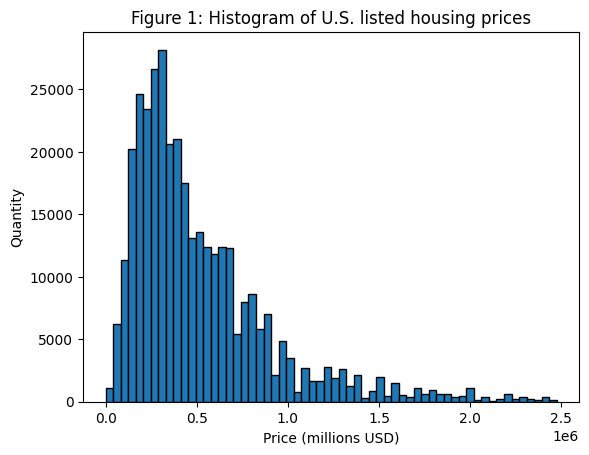

In [9]:
#plotting histagram for price variable
plt.hist(data['price'],bins=60,edgecolor='black')
plt.title("Figure 1: Histogram of U.S. listed housing prices")
plt.ylabel("Quantity")
plt.xlabel("Price (millions USD)")

PHF 2
THis histogram displays the distribution of U.S. listed house prices. An interesting finding of this histogram is the clear jumps at every $50,000 USD. This could be due to real-estate sellers preferring round numbers when listing houses.

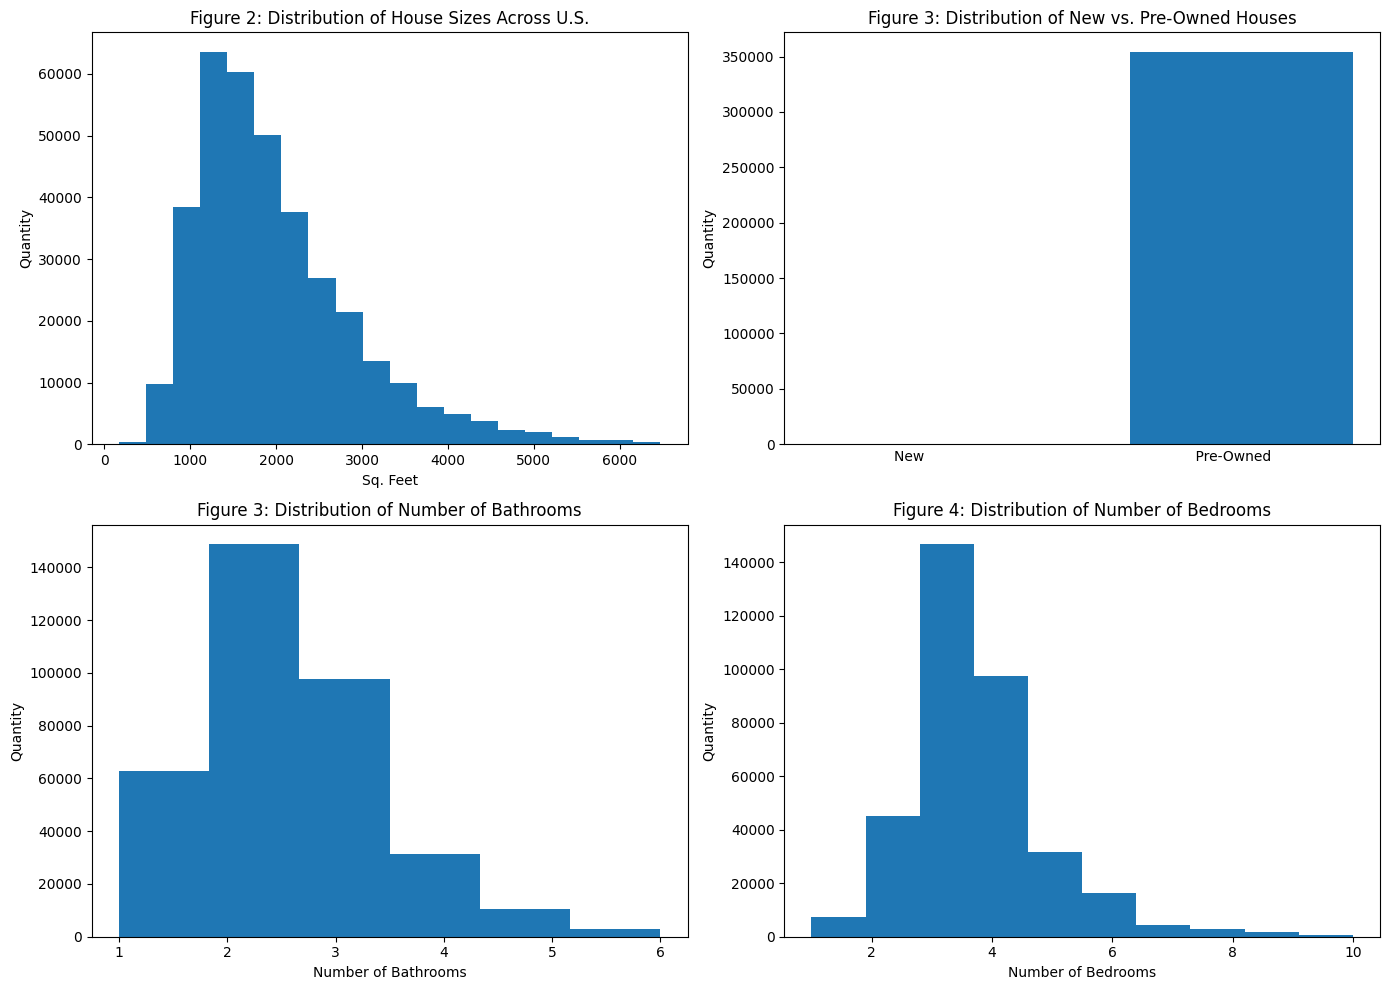

In [45]:
fig, fig_1 = plt.subplots(2,2,figsize=(14,10))

#plotting histogram for house_size
fig_1[0,0].hist(data["house_size"], bins=20)
fig_1[0,0].set_title("Figure 2: Distribution of House Sizes Across U.S.")
fig_1[0,0].set_xlabel('Sq. Feet')
fig_1[0,0].set_ylabel('Quantity')

#plotting histogram for sold_before 
fig_1[0,1].hist(data["sold_before"], bins=2, rwidth=0.7, align='mid')
fig_1[0,1].set_title("Figure 3: Distribution of New vs. Pre-Owned Houses")
#customising x-axis for dummy
fig_1[0,1].set_xticks([])
fig_1[0,1].set_xlabel('New                                                              Pre-Owned')
fig_1[0,1].set_ylabel('Quantity')

#plotting histogram for # of baths
fig_1[1,0].hist(data['bath'], bins=6)
fig_1[1,0].set_title("Figure 3: Distribution of Number of Bathrooms")
fig_1[1,0].set_xlabel('Number of Bathrooms')
fig_1[1,0].set_ylabel('Quantity')

#plotting histogram for # of bedrooms
fig_1[1,1].hist(data['bed'], bins=10)
fig_1[1,1].set_title("Figure 4: Distribution of Number of Bedrooms")
fig_1[1,1].set_xlabel('Number of Bedrooms')
fig_1[1,1].set_ylabel('Quantity')

plt.tight_layout()

PHF 3 - describe histograms

PHF 4 - introduce more complex graphs for New-York, New-Jersey, Massachusetts, and Connecticut

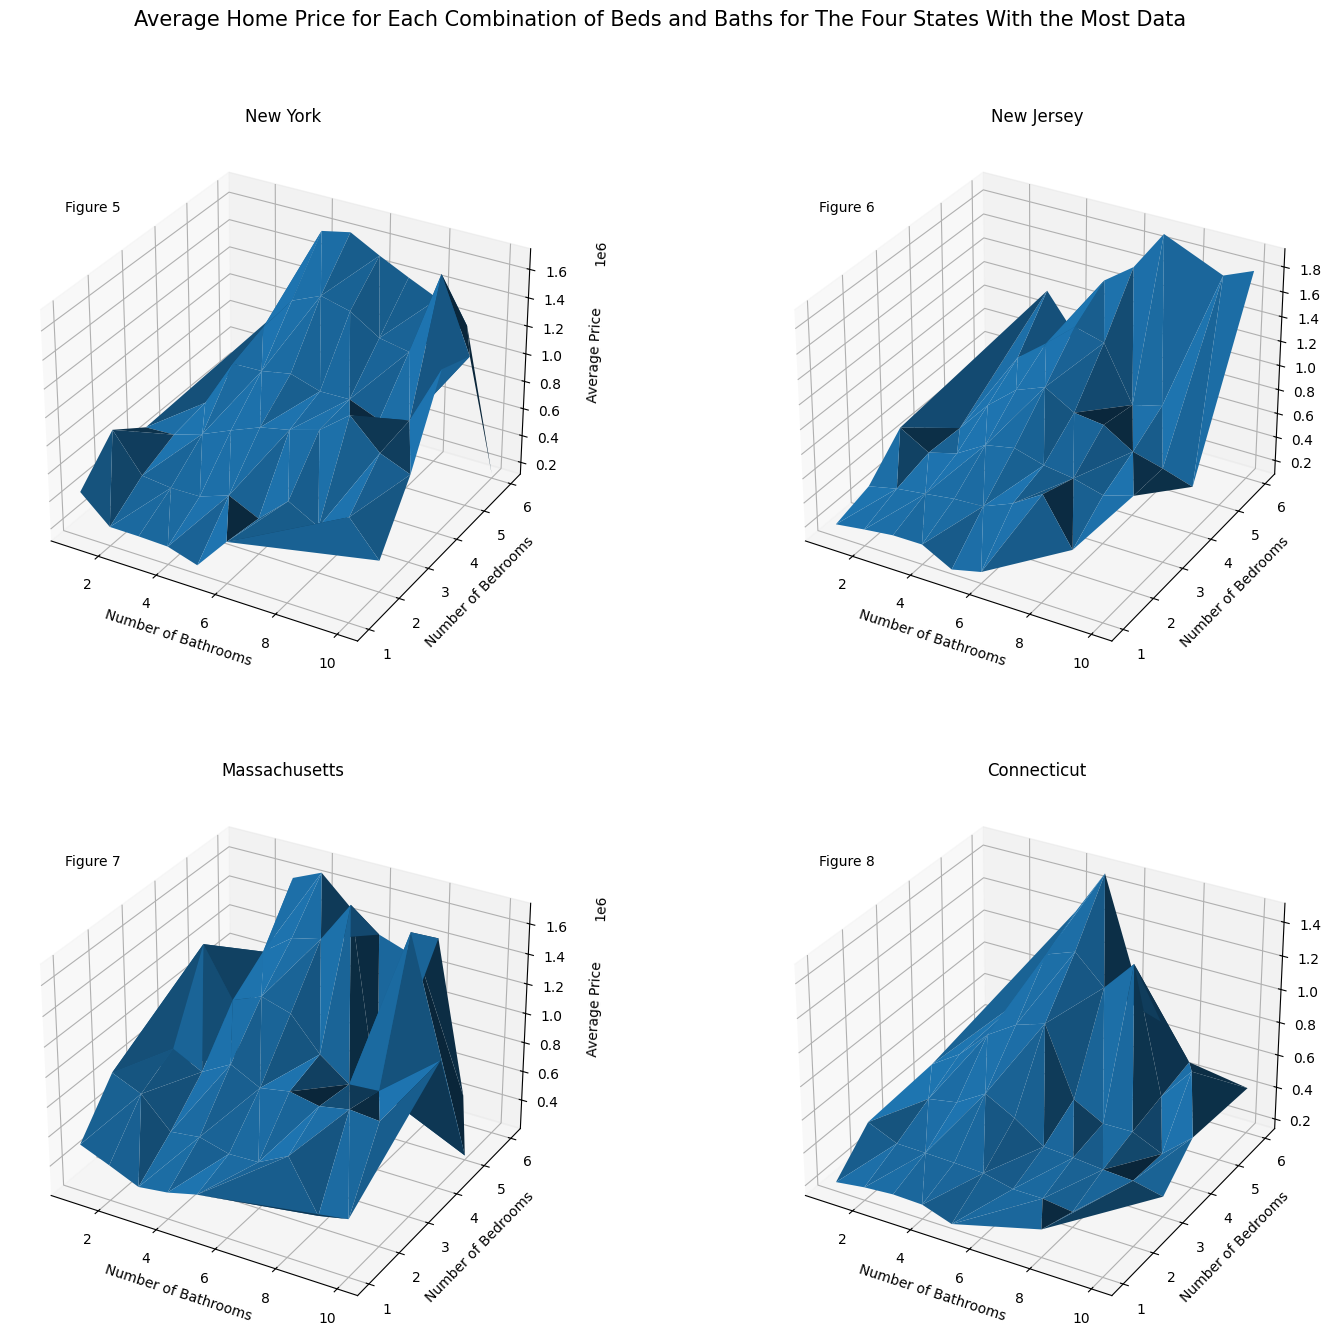

In [37]:
def prepare_and_plot(state, subplot_position, fig, data_by_state):
    pivot_table = data_by_state.get_group(state).pivot_table(values='price', index='bed', columns='bath', aggfunc='mean')
    pivot_table = pivot_table.stack().reset_index()
    pivot_table.columns = ['bed', 'bath', 'average_price']

    beds = pivot_table['bed']
    baths = pivot_table['bath']
    average_price = pivot_table['average_price']

    ax = fig.add_subplot(2, 2, subplot_position, projection='3d')
    ax.plot_trisurf(beds, baths, average_price)
    ax.set_xlabel('Number of Bathrooms')
    ax.set_ylabel('Number of Bedrooms')
    ax.set_zlabel('Average Price', fontsize=10, labelpad=10) 
    ax.set_title(state)

    # Add figure label if needed, e.g., 'A', 'B', 'C', 'D'
    ax.text2D(0.1, 0.85, f'Figure {subplot_position + 4}', transform=ax.transAxes)

fig_2 = plt.figure(figsize=(18, 15))
#Title for whole figure
fig_2.suptitle('Average Home Price for Each Combination of Beds and Baths for The Four States With the Most Data', fontsize=15)

states = ['New York', 'New Jersey', 'Massachusetts', 'Connecticut']

for i, state in enumerate(states, start=1):
    prepare_and_plot(state, i, fig_2, data_by_state)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.2)

plt.show()